<a href="https://colab.research.google.com/github/Galahexolion/SAM-skrydziai/blob/main/SMAprojektas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import community.community_louvain as community_louvain
from google.colab import files

# 1. DUOMENŲ GAVIMAS IŠ OPENFLIGHTS

# Nuorodos į oficialius OpenFlights duomenis (GitHub)
airports_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
routes_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

# A. Nuskaitome Oro uostus
# OpenFlights neturi stulpelių pavadinimų faile, pridedame patys
airport_cols = ["ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "Tz", "Type", "Source"]
df_airports = pd.read_csv(airports_url, header=None, names=airport_cols, na_values="\\N")

# B. Nuskaitome Maršrutus
route_cols = ["Airline", "AirlineID", "SourceAirport", "SourceAirportID", "DestAirport", "DestAirportID", "Codeshare", "Stops", "Equipment"]
df_routes = pd.read_csv(routes_url, header=None, names=route_cols, na_values="\\N")

# 2. FILTRAVIMAS (Mums reikia tik ~60-80 mazgų Europoje)

# Pasirenkame šalis, kad gautume gražų Europos tinklą
europe_countries = [
    "Lithuania", "Latvia", "Estonia", "Poland", "Germany", "France", "United Kingdom",
    "Italy", "Spain", "Netherlands", "Belgium", "Austria", "Switzerland", "Denmark",
    "Sweden", "Norway", "Finland", "Ireland", "Portugal", "Greece", "Czech Republic", "Hungary"
]

# Filtruojame oro uostus pagal šalis
europe_airports = df_airports[df_airports['Country'].isin(europe_countries)].copy()

# Filtruojame maršrutus: pasiliekame tik tuos, kur IŠ ir Į yra mūsų Europos sąraše
# (Naudojame IATA kodus, pvz., VNO, LHR)
valid_iatas = europe_airports['IATA'].tolist()
europe_routes = df_routes[
    (df_routes['SourceAirport'].isin(valid_iatas)) &
    (df_routes['DestAirport'].isin(valid_iatas))
]

# Kad tinklas nebūtų per didelis, imame tik TOP 70 oro uostų pagal skrydžių skaičių
# (Taip išmesime mažus aerodromus, kurie neturi ryšių)
active_airports_counts = europe_routes['SourceAirport'].value_counts()
top_70_iatas = active_airports_counts.head(70).index.tolist()

# Įtraukiame Vilnių (VNO), jei netyčia nepateko į TOP 70 (dėl įdomumo)
if 'VNO' not in top_70_iatas:
    top_70_iatas.append('VNO')

# Galutinis filtravimas
final_airports = europe_airports[europe_airports['IATA'].isin(top_70_iatas)].copy()
final_routes = europe_routes[
    (europe_routes['SourceAirport'].isin(top_70_iatas)) &
    (europe_routes['DestAirport'].isin(top_70_iatas))
].copy()

# Išvalome dublikatus (jei kelios avialinijos skrenda tuo pačiu maršrutu, mums tai viena briauna)
final_routes_unique = final_routes[['SourceAirport', 'DestAirport']].drop_duplicates()

# 3. IŠSAUGOJIMAS (Jūsų Moodle failai)

# Sutvarkome stulpelius gražiam CSV failui
# Mums reikia skaitinių atributų klasterizavimui: Latitude, Longitude, Altitude, Timezone
nodes_export = final_airports[['IATA', 'Name', 'City', 'Country', 'Latitude', 'Longitude', 'Altitude', 'Timezone']]
nodes_export.rename(columns={'IATA': 'ID'}, inplace=True)

edges_export = final_routes_unique.rename(columns={'SourceAirport': 'Source', 'DestAirport': 'Target'})

# Išsaugome
nodes_export.to_csv("openflights_nodes.csv", index=False)
edges_export.to_csv("openflights_edges.csv", index=False)

# Atsisiunčiame
files.download("openflights_nodes.csv")
files.download("openflights_edges.csv")

print(f"Tinklas paruoštas! Mazgų: {len(nodes_export)}, Briaunų: {len(edges_export)}")
print("Atributai analizei: Latitude (geografinė padėtis), Timezone (laiko juosta), Altitude (aukštis).")

/tmp/ipython-input-4047576797.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_export.rename(columns={'IATA': 'ID'}, inplace=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tinklas paruoštas! Mazgų: 71, Briaunų: 2895
Atributai analizei: Latitude (geografinė padėtis), Timezone (laiko juosta), Altitude (aukštis).


Failai nuskaityti.

REZULTATAI (TOP 5 + VILNIUS)

--- TOP 5 Oro uostai pagal Tiesioginius skrydžius (Degree) ---
    ID       City    Degree
0  AMS  Amsterdam  0.942857
1  DUB     Dublin  0.928571
2  BCN  Barcelona  0.928571
3  MUC     Munich  0.871429
4  BRU   Brussels  0.842857

... (praleidžiame 65 oro uostus) ...
70.  VNO   Vilnius    0.300000  <-- VILNIUS (Vieta: 71 iš 71)


--- TOP 5 Tarpininkai (Betweenness) ---
    ID       City  Betweenness
0  DUB     Dublin     0.018756
1  BCN  Barcelona     0.018465
2  AMS  Amsterdam     0.018426
3  CDG      Paris     0.014185
4  BRU   Brussels     0.014090

... (praleidžiame 64 oro uostus) ...
69.  VNO   Vilnius    0.001256  <-- VILNIUS (Vieta: 70 iš 71)


Tinklo tankis: 0.5843
Paveiksliukas '2_dalis_tinklas.png' sukurtas ir siunčiamas...


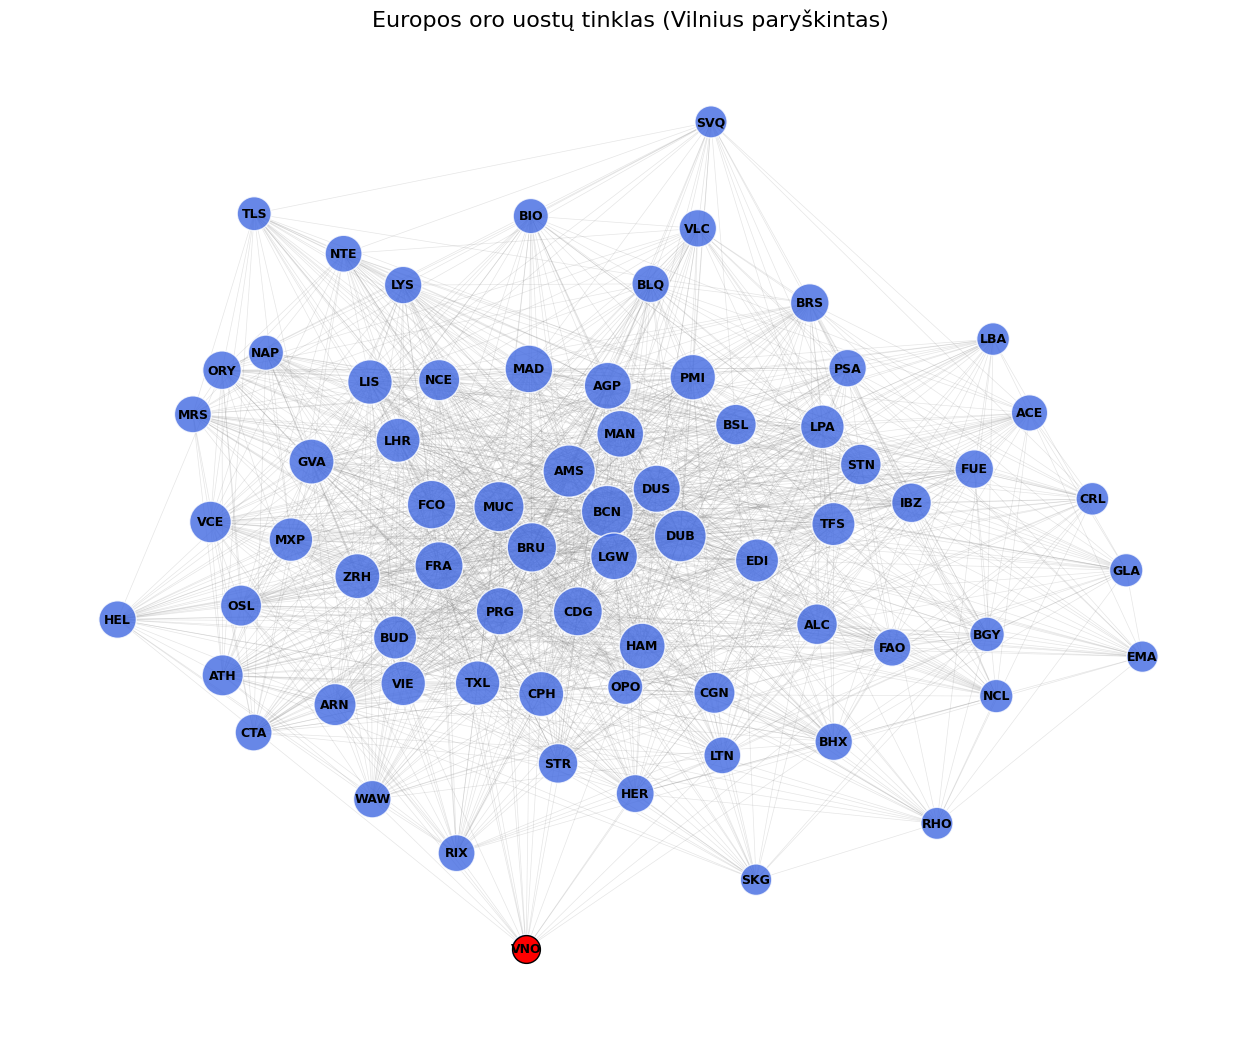

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# --- 2 DALIS: TINKLO PARAMETRAI IR VIZUALIZACIJA ---
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import files

# 1. Nuskaitome failus
try:
    df_nodes = pd.read_csv('openflights_nodes.csv')
    df_edges = pd.read_csv('openflights_edges.csv')
    print("Failai nuskaityti.")
except FileNotFoundError:
    print("KLAIDA: Nerasti failai! Įsitikinkite, kad 1 žingsnis atliktas.")

# 2. Sukuriame tinklą
G = nx.from_pandas_edgelist(df_edges, source='Source', target='Target')

# 3. Skaičiuojame parametrus
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

df_nodes['Degree'] = df_nodes['ID'].map(degree)
df_nodes['Betweenness'] = df_nodes['ID'].map(betweenness)

# 4. REZULTATAI
print("\n" + "="*60)
print("REZULTATAI (TOP 5 + VILNIUS)")
print("="*60)

# --- POPULIARUMAS (DEGREE) ---
print("\n--- TOP 5 Oro uostai pagal Tiesioginius skrydžius (Degree) ---")
sorted_degree = df_nodes.sort_values('Degree', ascending=False).reset_index(drop=True)
print(sorted_degree[['ID', 'City', 'Degree']].head(5))

# --- VILNIAUS VIETA (DEGREE) ---
if 'VNO' in df_nodes['ID'].values:
    vno_idx = sorted_degree[sorted_degree['ID'] == 'VNO'].index[0]
    vno_row = sorted_degree.iloc[vno_idx]
    print(f"\n... (praleidžiame {vno_idx - 5} oro uostus) ...")
    print(f"{vno_idx}.  {vno_row['ID']}   {vno_row['City']}    {vno_row['Degree']:.6f}  <-- VILNIUS (Vieta: {vno_idx+1} iš {len(df_nodes)})")

# --- TARPININKAVIMAS (BETWEENNESS) ---
print("\n\n--- TOP 5 Tarpininkai (Betweenness) ---")
sorted_betweenness = df_nodes.sort_values('Betweenness', ascending=False).reset_index(drop=True)
print(sorted_betweenness[['ID', 'City', 'Betweenness']].head(5))

# --- VILNIAUS VIETA (BETWEENNESS) ---
if 'VNO' in df_nodes['ID'].values:
    vno_idx_b = sorted_betweenness[sorted_betweenness['ID'] == 'VNO'].index[0]
    vno_row_b = sorted_betweenness.iloc[vno_idx_b]
    print(f"\n... (praleidžiame {vno_idx_b - 5} oro uostus) ...")
    print(f"{vno_idx_b}.  {vno_row_b['ID']}   {vno_row_b['City']}    {vno_row_b['Betweenness']:.6f}  <-- VILNIUS (Vieta: {vno_idx_b+1} iš {len(df_nodes)})")

print(f"\n\nTinklo tankis: {nx.density(G):.4f}")

# 5. VIZUALIZACIJA (Su RAUDONU Vilniumi)
plt.figure(figsize=(16, 13))
pos = nx.spring_layout(G, seed=42, k=0.18)

# Braižome visus mazgus
nx.draw_networkx_nodes(G, pos, node_size=[v * 1500 for v in degree.values()],
                       node_color='royalblue', alpha=0.8, edgecolors='white')

# Braižome VILNIŲ atskirai (Raudonas)
if 'VNO' in G.nodes():
    nx.draw_networkx_nodes(G, pos, nodelist=['VNO'], node_size=400,
                           node_color='red', alpha=1.0, edgecolors='black')

# Braižome briaunas
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.2, edge_color='gray')

# Etiketės (Visiems)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_color='black')

plt.title("Europos oro uostų tinklas (Vilnius paryškintas)", fontsize=16)
# plt.legend() - PAŠALINTA
plt.axis('off')

# Išsaugome
plt.savefig("2_dalis_tinklas.png", dpi=300, bbox_inches='tight')
print("Paveiksliukas '2_dalis_tinklas.png' sukurtas ir siunčiamas...")
plt.show()
files.download("2_dalis_tinklas.png")


REZULTATAI (APTIKTA BENDRUOMENIŲ: 3)

Bendruomenė 0:
   Dominuoja: Spain (9), United Kingdom (9), Italy (2)

Bendruomenė 1:
   Dominuoja: Germany (6), Greece (4), France (3)

Bendruomenė 2:
   Dominuoja: France (5), Italy (4), Spain (4)


/tmp/ipython-input-1892165186.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_communities)



Paveiksliukas '3_dalis_bendruomenes.png' sukurtas ir siunčiamas...


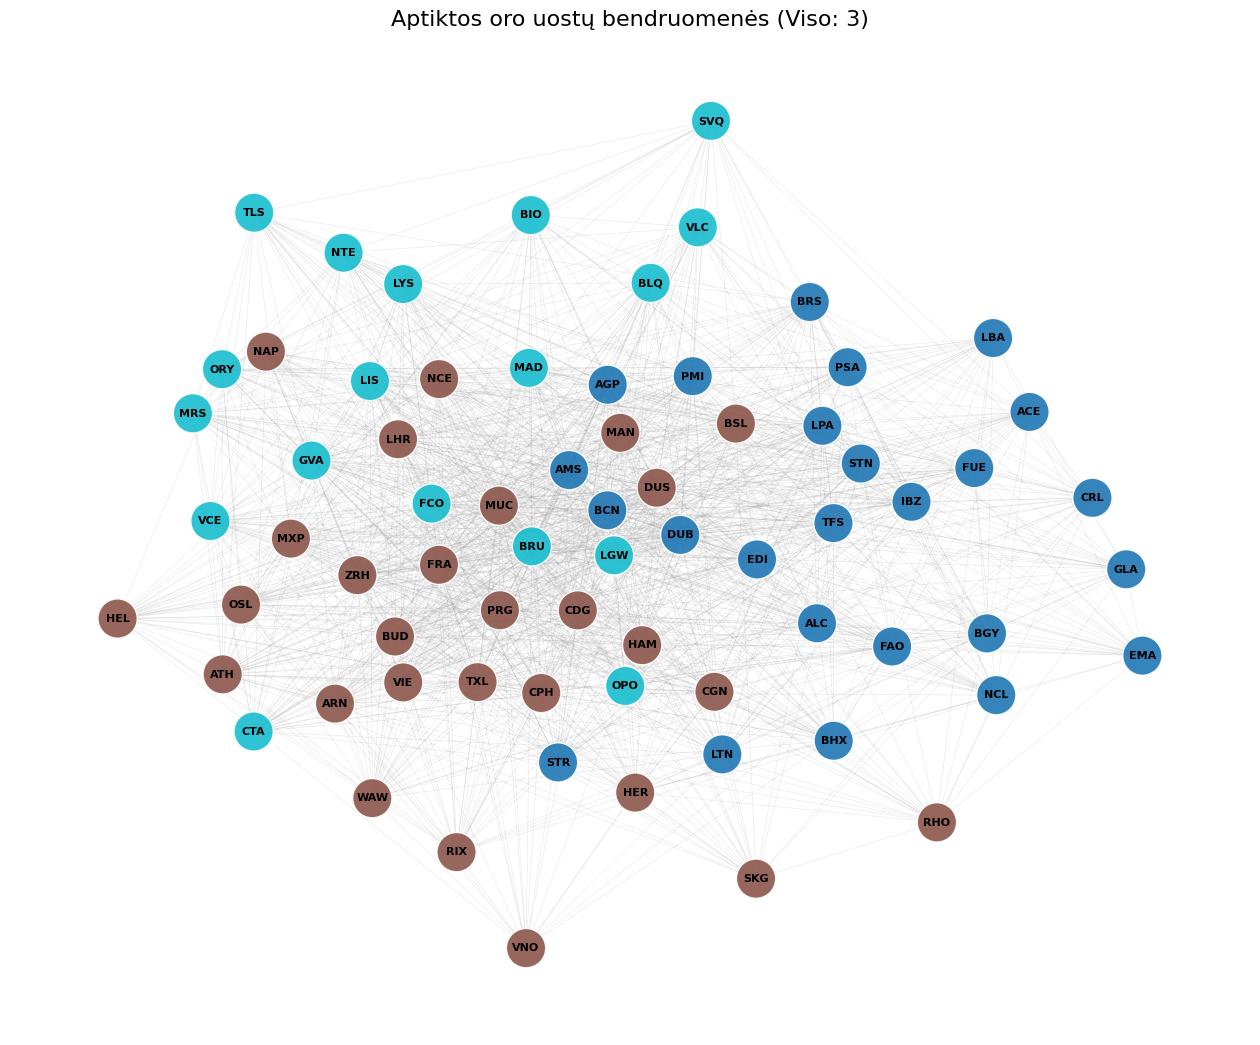

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# --- 3 DALIS: BENDRUOMENIŲ APTIKIMAS (Louvain algoritmas) ---
import community.community_louvain as community_louvain
import matplotlib.cm as cm
from google.colab import files

# 1. Skaičiuojame bendruomenes
# Algoritmas ieško grupių, kurios viduje turi daugiau ryšių nei su išore
partition = community_louvain.best_partition(G)

# Pridedame informaciją į lentelę
df_nodes['Community'] = df_nodes['ID'].map(partition)

# 2. Rezultatų išvedimas į ekraną
num_communities = len(set(partition.values()))
print(f"\n" + "="*60)
print(f"REZULTATAI (APTIKTA BENDRUOMENIŲ: {num_communities})")
print("="*60)

# Parodome, kas sudaro kiekvieną bendruomenę
composition = pd.crosstab(df_nodes['Community'], df_nodes['Country'])

for i in range(num_communities):
    if i in composition.index:
        # Paimame TOP 3 šalis toje grupėje
        top_countries = composition.loc[i].sort_values(ascending=False).head(3)
        print(f"\nBendruomenė {i}:")
        country_list = []
        for country, count in top_countries.items():
            if count > 0:
                country_list.append(f"{country} ({count})")
        print("   Dominuoja: " + ", ".join(country_list))

# 3. VIZUALIZACIJA IR IŠSAUGOJIMAS
plt.figure(figsize=(16, 13))
pos = nx.spring_layout(G, seed=42, k=0.18)

# Nuspalviname pagal bendruomenes
# Sukuriame spalvų žemėlapį
cmap = cm.get_cmap('tab10', num_communities)

# Braižome mazgus
nx.draw_networkx_nodes(G, pos, node_size=800,
                       node_color=list(partition.values()), cmap=cmap, alpha=0.9, edgecolors='white')

# Braižome briaunas
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.15, edge_color='gray')

# Pridedame etiketes (pavadinimus)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', font_color='black')

plt.title(f"Aptiktos oro uostų bendruomenės (Viso: {num_communities})", fontsize=16)
plt.axis('off')

# Išsaugome
plt.savefig("3_dalis_bendruomenes.png", dpi=300, bbox_inches='tight')
print("\nPaveiksliukas '3_dalis_bendruomenes.png' sukurtas ir siunčiamas...")
plt.show()

# Atsisiunčiame
files.download("3_dalis_bendruomenes.png")

In [9]:
# --- 4 DALIS: KLASTERIZAVIMAS PAGAL ATRIBUTUS (K-Means) ---
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Pasirenkame duomenis grupavimui
# Oro uostus grupuosime TIK pagal geografiją (kur jie yra), ignoruojant skrydžius
features = df_nodes[['Latitude', 'Longitude', 'Timezone']].fillna(0)

# 2. Standartizuojame duomenis (kad skaičiai būtų vienodame mastelyje)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 3. Ieškome 3 regionų (K-Means algoritmas)
# (Galime ieškoti 3, kad būtų lengviau lyginti su 3 tinklo bendruomenėmis)
kmeans = KMeans(n_clusters=3, random_state=42)
df_nodes['Cluster_Geo'] = kmeans.fit_predict(features_scaled)

# 4. Rezultatų išvedimas į ekraną
print("\n" + "="*60)
print("4 DALIES REZULTATAI (K-Means)")
print("="*60)
print("Oro uostai sugrupuoti į 3 geografinius regionus pagal koordinates.")
print("\nKiek oro uostų pateko į kiekvieną geografinį klasterį:")
print(df_nodes['Cluster_Geo'].value_counts().sort_index())

# Parodome pavyzdžius (pirmus 3 iš kiekvieno klasterio)
print("\nKlasterių pavyzdžiai:")
for i in range(3):
    cities = df_nodes[df_nodes['Cluster_Geo'] == i]['City'].head(3).tolist()
    print(f"  Klasteris {i}: {', '.join(cities)}...")


4 DALIES REZULTATAI (K-Means)
Oro uostai sugrupuoti į 3 geografinius regionus pagal koordinates.

Kiek oro uostų pateko į kiekvieną geografinį klasterį:
Cluster_Geo
0    19
1    36
2    16
Name: count, dtype: int64

Klasterių pavyzdžiai:
  Klasteris 0: Frankfurt, Hamburg, Munich...
  Klasteris 1: Brussels, Charleroi, Cologne...
  Klasteris 2: Birmingham, Manchester, Bristol...



Paveiksliukas '5_dalis_palyginimas.png' sukurtas ir siunčiamas...


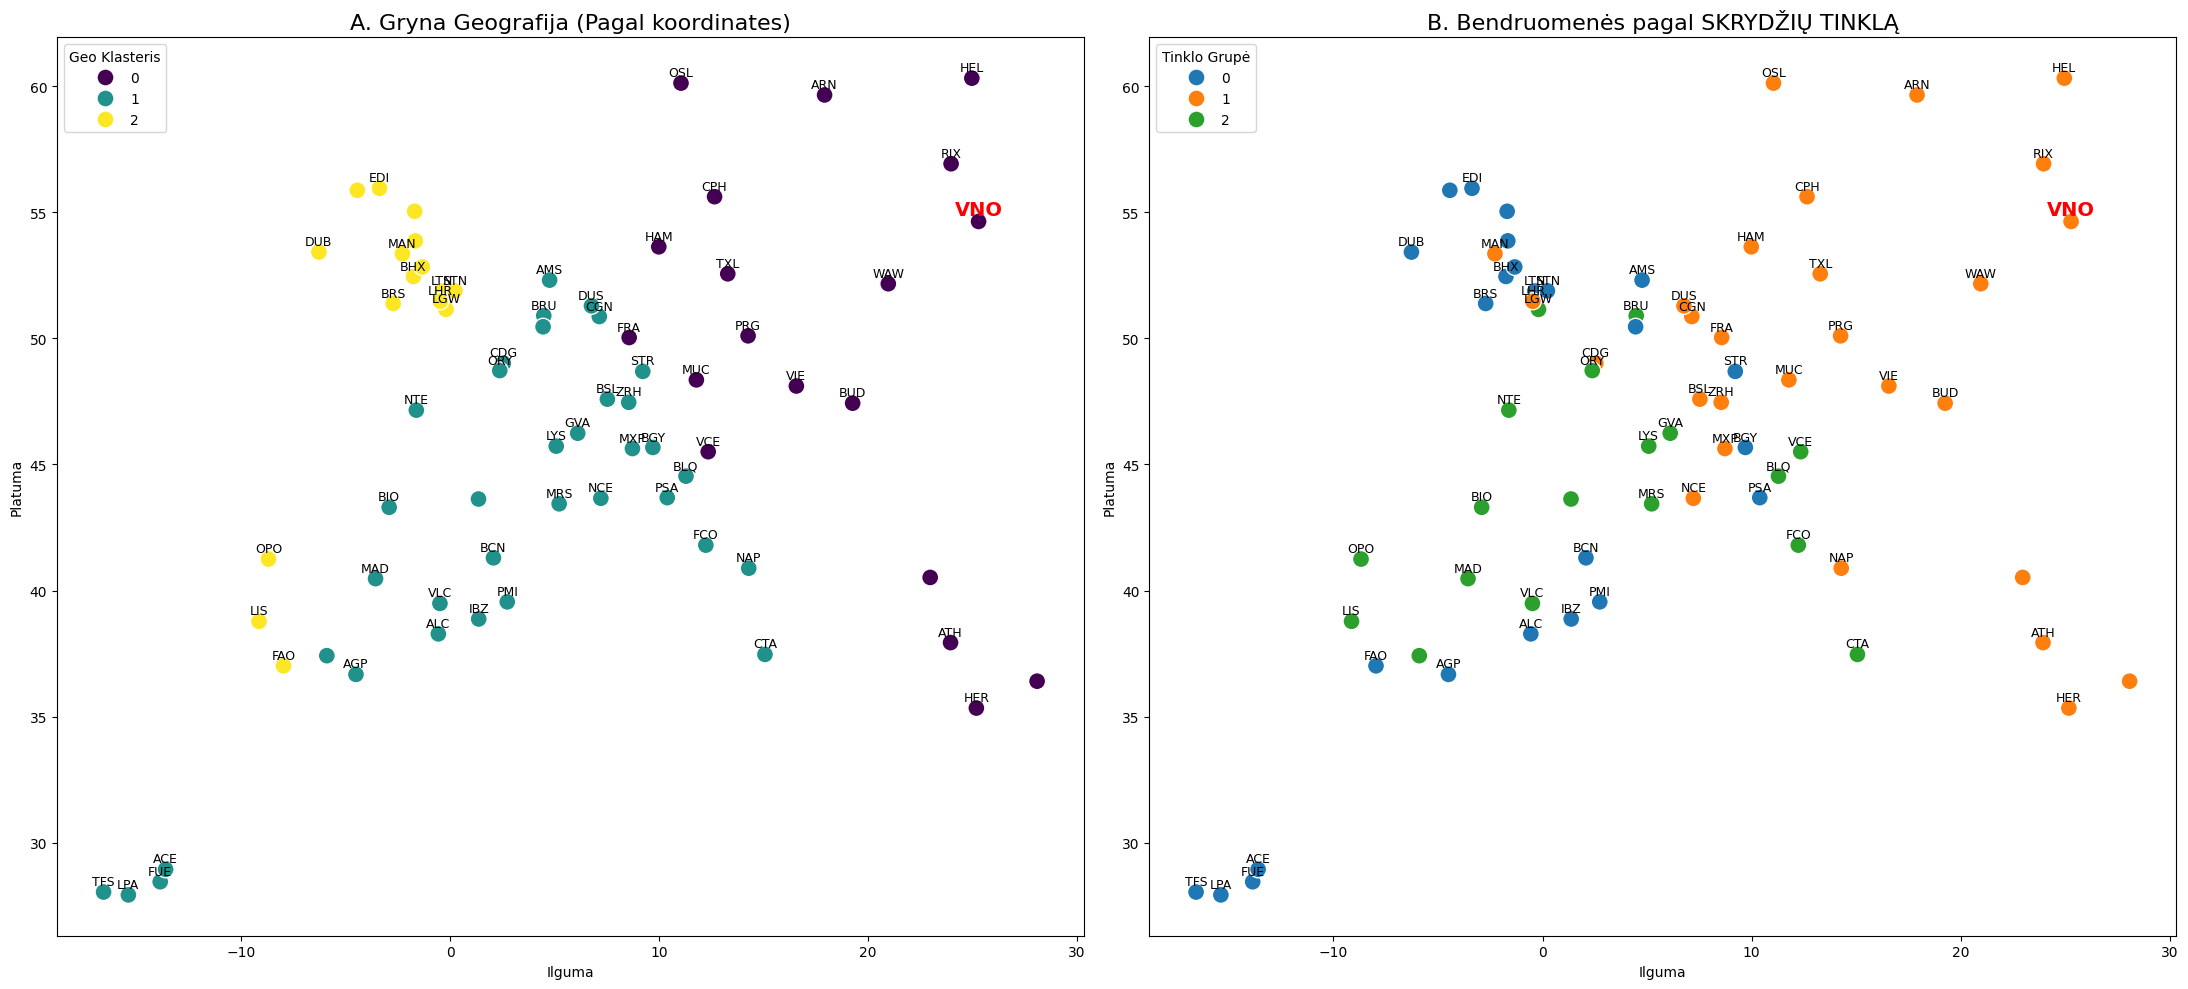

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# --- 5 DALIS: VIZUALUS PALYGINIMAS (Su VNO) ---
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Paruošiame drobę dviem grafikams
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# --- A GRAFIKAS: PAGAL GEOGRAFIJĄ (K-Means) ---
sns.scatterplot(data=df_nodes, x='Longitude', y='Latitude', hue='Cluster_Geo', palette='viridis', s=150, ax=axes[0], legend='full')
axes[0].set_title('A. Gryna Geografija (Pagal koordinates)', fontsize=16)
axes[0].set_xlabel('Ilguma'); axes[0].set_ylabel('Platuma')
axes[0].legend(title='Geo Klasteris')

# --- B GRAFIKAS: PAGAL TINKLĄ (Louvain) ---
sns.scatterplot(data=df_nodes, x='Longitude', y='Latitude', hue='Community', palette='tab10', s=150, ax=axes[1], legend='full')
axes[1].set_title('B. Bendruomenės pagal SKRYDŽIŲ TINKLĄ', fontsize=16)
axes[1].set_xlabel('Ilguma'); axes[1].set_ylabel('Platuma')
axes[1].legend(title='Tinklo Grupė')

# --- ETIKETĖS (Pavadinimai) ---
# Uždedame pavadinimus ant abiejų grafikų (VNO + Lyderiai)
for ax in axes:
    for i, txt in enumerate(df_nodes['ID']):
        # Rodome VNO ir didžiausius oro uostus (>0.4 populiarumo), kad neapkrautume vaizdo
        if df_nodes['Degree'][i] > 0.4 or txt == 'VNO':
            # Jei tai Vilnius - paryškiname raudonai
            color = 'red' if txt == 'VNO' else 'black'
            weight = 'bold' if txt == 'VNO' else 'normal'
            size = 14 if txt == 'VNO' else 9

            ax.annotate(txt, (df_nodes['Longitude'][i], df_nodes['Latitude'][i]),
                        fontsize=size, fontweight=weight, color=color,
                        textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()

# Išsaugome
plt.savefig("5_dalis_palyginimas.png", dpi=300, bbox_inches='tight')
print("\nPaveiksliukas '5_dalis_palyginimas.png' sukurtas ir siunčiamas...")
plt.show()

# Atsisiunčiame
files.download("5_dalis_palyginimas.png")